# COURSE: A deep understanding of deep learning
## SECTION: Understand and design CNNs
### LECTURE: CodeChallenge: Custom loss functions
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [128]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/var/folders/4x/pds2gxg17h57rrp30d736s1w0000gn/T/ipykernel_17154/1319117283.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Create Gaussian blurs with varying widths and occluding bars

In [129]:
nGauss  = 1000
imgSize = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# vary the weights smoothly
widths = np.linspace(2,20,nGauss)

# initialize tensor containing images
images = torch.zeros(nGauss,1,imgSize,imgSize)

for i in range(nGauss):

  # create the gaussian with random centers
  ro = 1.5*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i] )
  
  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5

  # add a random bar randomly
  i1 = np.random.choice(np.arange(2,28))
  i2 = np.random.choice(np.arange(2,6))
  if np.random.randn()>0:
    G[i1:i1+i2,] = 1
  else:
    G[:,i1:i1+i2] = 1
  
  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

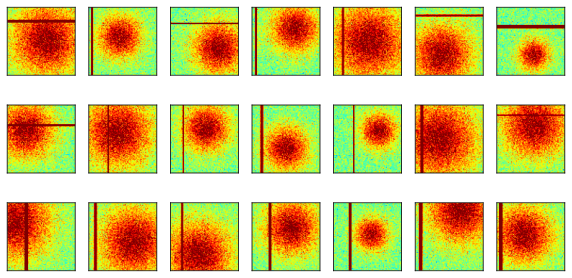

In [130]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(10,5))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nGauss)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Custom loss functions

In [131]:
# L1 loss function

class myL1Loss(nn.Module):
  def __init__(self):
    super().__init__()
      
  def forward(self,yHat,y):
    l = torch.mean( torch.abs(yHat-y) )
    return l

In [132]:
# L2+average loss function

class myL2AveLoss(nn.Module):
  def __init__(self):
    super().__init__()
      
  def forward(self,yHat,y):
    # MSE part
    l = torch.mean( (yHat-y)**2 )

    # average part
    a = torch.abs(torch.mean(yHat))

    # sum together
    return l + a

In [133]:
# correlation loss function

class myCorLoss(nn.Module):
  def __init__(self):
    super().__init__()
      
  def forward(self,yHat,y):
    
    meanx = torch.mean(yHat)
    meany = torch.mean(y)

    num = torch.sum( (yHat-meanx)*(y-meany) )
    den = (torch.numel(y)-1) * torch.std(yHat) * torch.std(y)
    return -num/den

In [134]:
# correlation loss function

class myLossFn(nn.Module):
  def __init__(self):
    super().__init__()
      
  def forward(self,yHat):

    return torch.std(yHat)

# Create the DL model

In [135]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()
      
      # encoding layer
      self.enc = nn.Sequential(
          nn.Conv2d(1,6,3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.Conv2d(6,4,3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2)  
          )
      
      # decoding layer
      self.dec = nn.Sequential(
          nn.ConvTranspose2d(4,6,3,2),
          nn.ReLU(),
          nn.ConvTranspose2d(6,1,3,2),
          )
      
    def forward(self,x):
      return self.dec( self.enc(x) )
  
  # create the model instance
  net = gausnet()
  
  # loss functions (leave one uncommented!)
  # lossfun = nn.MSELoss()
#   lossfun = myL1Loss()
  lossfun = myL2AveLoss()
#   lossfun = myCorLoss()
#   lossfun = myLossFn()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

# Create a function that trains the model

In [136]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 1000
  
  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  losses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # pick a set of images at random
    pics2use = np.random.choice(nGauss,size=32,replace=False)
    X = images[pics2use,:,:,:]

    # forward pass and loss
    yHat = net(X)
    loss = lossfun(yHat,X)
#     loss = lossfun(yHat)
    losses[epochi] = loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # end epochs

  # function output
  return losses,net

# Run the model and show the results!

In [137]:
# train the model!
losses,net = function2trainTheModel()

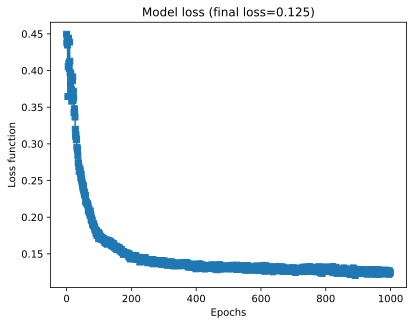

In [138]:
plt.plot(losses,'s-',label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.title('Model loss (final loss=%.3f)'%losses[-1])

plt.show()

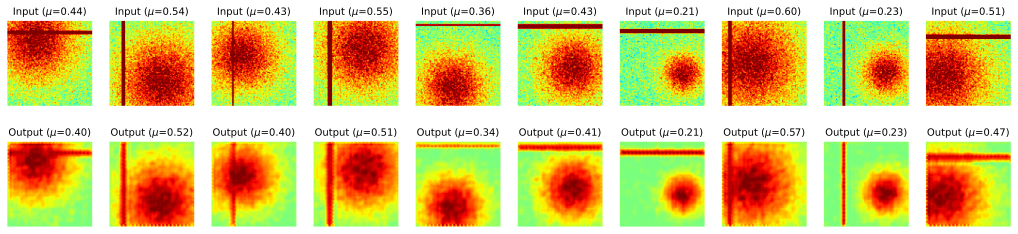

In [139]:
# visualize some images

pics2use = np.random.choice(nGauss,size=32,replace=False)
X = images[pics2use,:,:,:]
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(18,4))

for i in range(10):
  
  G = torch.squeeze( X[i,0,:,:] ).detach()
  O = torch.squeeze( yHat[i,0,:,:] ).detach()
  
  axs[0,i].imshow(G,vmin=-1,vmax=1,cmap='jet')
  axs[0,i].axis('off')
  axs[0,i].set_title('Input ($\mu$=%.2f)'%torch.mean(G).item(),fontsize=10)

  axs[1,i].imshow(O,vmin=-1,vmax=1,cmap='jet')
  axs[1,i].axis('off')
  axs[1,i].set_title('Output ($\mu$=%.2f)'%torch.mean(O).item(),fontsize=10)

plt.show()

# Additional explorations

In [140]:
# 1) The code in this notebook requires "manually" switching between loss functions by (un)commenting. Modify the
#    code so that you can list the name of the loss function as an input to makeTheNet().
# 
# 2) Here's an interesting loss function: minimize the variance of the model's output. Don't worry about comparing
#    to the input image; just set the loss function to be the variance of the output. What do the results look like,
#    and why does this happen?
# MY COMMENT: All values converge to a single value with 0 stdev. That's because our loss function is stdev(output)
# 3) What if L2 minimization (MSE) is more important than average minimization? Modify the L2LossAve class so that the
#    average has a weaker influence compared to the L2 loss.
# MY COMMENT: As we make the average have a weaker influence compared to the L2 loss, result converges to MSE.
# 
# Reminder: This codeChallenge was designed to be a fun exercise to introduce you to the mechanics of creating and using
#           custom-built loss functions. The PyTorch built-in MSELoss is actually the best one to use for autoencoders
#           in most cases.
# 